### Problem Statement

    Identify products at risk of backorder before the event occurs so that business has time to react.

### What is a Backorder?
Backorders are products that are temporarily out of stock, but a customer is permitted to place an order against future inventory. A backorder generally indicates that customer demand for a product or service exceeds a company’s capacity to supply it. Back orders are both good and bad. Strong demand can drive back orders, but so can suboptimal planning.

### Data

Data file contains the historical data for the 8 weeks prior to the week we are trying to predict. The data was taken as weekly snapshots at the start of each week. Columns are defined as follows:

    sku - Random ID for the product

    national_inv - Current inventory level for the part

    lead_time - Transit time for product (if available)

    in_transit_qty - Amount of product in transit from source

    forecast_3_month - Forecast sales for the next 3 months

    forecast_6_month - Forecast sales for the next 6 months

    forecast_9_month - Forecast sales for the next 9 months

    sales_1_month - Sales quantity for the prior 1 month time period

    sales_3_month - Sales quantity for the prior 3 month time period

    sales_6_month - Sales quantity for the prior 6 month time period

    sales_9_month - Sales quantity for the prior 9 month time period

    min_bank - Minimum recommend amount to stock

    potential_issue - Source issue for part identified

    pieces_past_due - Parts overdue from source

    perf_6_month_avg - Source performance for prior 6 month period

    perf_12_month_avg - Source performance for prior 12 month period

    local_bo_qty - Amount of stock orders overdue

    deck_risk - Part risk flag

    oe_constraint - Part risk flag

    ppap_risk - Part risk flag

    stop_auto_buy - Part risk flag

    rev_stop - Part risk flag

    went_on_backorder - Product actually went on backorder. This is the target value.

### Data Pre-processing
#### Loading the required libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras import optimizers

import matplotlib.pyplot as plt
%matplotlib inline  
import os

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


#### Loading the data

In [2]:
os.getcwd()

'/Users/seemabasantani/Documents/Academics/Batch 56/CSE7321c/ANN/Lab/20181215_Batch47_CSE7321c_Lab02_ANN/20181215_Batch47_CSE7321c_Lab02'

In [3]:
#For setting working directory, if required
#os.chdir('path to file)

In [4]:
data = pd.read_csv("BackOrders.csv",header=0)

#### Understand the Data

See the number row and columns

In [5]:
data.shape

(61589, 23)

Display the columns

In [6]:
data.columns

Index(['sku', 'national_inv', 'lead_time', 'in_transit_qty',
       'forecast_3_month', 'forecast_6_month', 'forecast_9_month',
       'sales_1_month', 'sales_3_month', 'sales_6_month', 'sales_9_month',
       'min_bank', 'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')

Display the index

In [7]:
data.index

RangeIndex(start=0, stop=61589, step=1)

See the top rows of the data

In [8]:
data[:3]

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,1888279,117,NaN,0,0,0,0,0,0,15,...,0,-99.00,-99.00,0,No,No,Yes,Yes,No,No
1,1870557,7,2.0,0,0,0,0,0,0,0,...,0,0.50,0.28,0,Yes,No,No,Yes,No,No
2,1475481,258,15.0,10,10,77,184,46,132,256,...,0,0.54,0.70,0,No,No,No,Yes,No,No


Shows a quick statistic summary of your data using describe.

For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. 

The top is the most common value.

The freq is the most common value’s frequency.

Timestamps also include the first and last items.

In [9]:
data.describe(include='all')

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
count,6.158900e+04,61589.000000,58186.000000,61589.000000,6.158900e+04,6.158900e+04,6.158900e+04,61589.000000,61589.000000,6.158900e+04,...,61589.000000,61589.000000,61589.000000,61589.000000,61589,61589,61589,61589,61589,61589
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2,2,2,2,2,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,No,No,Yes,No,No
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,48145,61577,53792,59303,61569,50296
mean,2.037188e+06,287.721882,7.559619,30.192843,1.692728e+02,3.150413e+02,4.535760e+02,44.742957,150.732631,2.835465e+02,...,1.605400,-6.264182,-5.863664,1.205361,NaN,NaN,NaN,NaN,NaN,NaN
std,6.564178e+05,4233.906931,6.498952,792.869253,5.286742e+03,9.774362e+03,1.420201e+04,1373.805831,5224.959649,8.872270e+03,...,42.309229,25.537906,24.844514,29.981155,NaN,NaN,NaN,NaN,NaN,NaN
min,1.068628e+06,-2999.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,-99.000000,-99.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,1.498574e+06,3.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,0.000000,0.620000,0.640000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,1.898033e+06,10.000000,8.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2.000000,4.000000e+00,...,0.000000,0.820000,0.800000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,2.314826e+06,57.000000,8.000000,0.000000,1.200000e+01,2.500000e+01,3.600000e+01,6.000000,17.000000,3.400000e+01,...,0.000000,0.960000,0.950000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN


Display data type of each variable

In [10]:
data.dtypes

sku                    int64
national_inv           int64
lead_time            float64
in_transit_qty         int64
forecast_3_month       int64
forecast_6_month       int64
forecast_9_month       int64
sales_1_month          int64
sales_3_month          int64
sales_6_month          int64
sales_9_month          int64
min_bank               int64
potential_issue       object
pieces_past_due        int64
perf_6_month_avg     float64
perf_12_month_avg    float64
local_bo_qty           int64
deck_risk             object
oe_constraint         object
ppap_risk             object
stop_auto_buy         object
rev_stop              object
went_on_backorder     object
dtype: object

#### Observations

sku is Categorical but is interpreted as int64 
potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder are also 
categorical but is interpreted as object. 

#### Convert all the attributes to appropriate type

Data type conversion

    Using astype('category') to convert potential_issue, deck_risk, oe_constraint, ppap_risk, stop_auto_buy, rev_stop, and went_on_backorder attributes to categorical attributes.


In [11]:
for col in ['sku', 'potential_issue', 'deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder']:
    data[col] = data[col].astype('category')

Display data type of each variable

In [12]:
data.dtypes

sku                  category
national_inv            int64
lead_time             float64
in_transit_qty          int64
forecast_3_month        int64
forecast_6_month        int64
forecast_9_month        int64
sales_1_month           int64
sales_3_month           int64
sales_6_month           int64
sales_9_month           int64
min_bank                int64
potential_issue      category
pieces_past_due         int64
perf_6_month_avg      float64
perf_12_month_avg     float64
local_bo_qty            int64
deck_risk            category
oe_constraint        category
ppap_risk            category
stop_auto_buy        category
rev_stop             category
went_on_backorder    category
dtype: object

##### Delete sku attribute

In [13]:
np.size(np.unique(data.sku))

61589

In [14]:
data.drop('sku', axis=1, inplace=True)

#### Missing Data

Missing value analysis and dropping the records with missing values

In [15]:
data.isnull().sum()

national_inv            0
lead_time            3403
in_transit_qty          0
forecast_3_month        0
forecast_6_month        0
forecast_9_month        0
sales_1_month           0
sales_3_month           0
sales_6_month           0
sales_9_month           0
min_bank                0
potential_issue         0
pieces_past_due         0
perf_6_month_avg        0
perf_12_month_avg       0
local_bo_qty            0
deck_risk               0
oe_constraint           0
ppap_risk               0
stop_auto_buy           0
rev_stop                0
went_on_backorder       0
dtype: int64

Observing the number of records before and after missing value records removal

In [16]:
print (data.shape)

(61589, 22)


In [17]:
#Since the number of missing values is about 5%. For initial analysis we ignore all these records
data = data.dropna(axis=0)

In [18]:
print(data.isnull().sum())
print("----------------------------------")
print(data.shape)

national_inv         0
lead_time            0
in_transit_qty       0
forecast_3_month     0
forecast_6_month     0
forecast_9_month     0
sales_1_month        0
sales_3_month        0
sales_6_month        0
sales_9_month        0
min_bank             0
potential_issue      0
pieces_past_due      0
perf_6_month_avg     0
perf_12_month_avg    0
local_bo_qty         0
deck_risk            0
oe_constraint        0
ppap_risk            0
stop_auto_buy        0
rev_stop             0
went_on_backorder    0
dtype: int64
----------------------------------
(58186, 22)


#### Converting Categorical to Numeric

For some of the models all the independent attribute should be of type numeric and ANN model is one among them.
But this data set has some categorial attributes.

'pandas.get_dummies' To convert convert categorical variable into dummy/indicator variables


In [19]:
print (data.columns)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'potential_issue', 'pieces_past_due', 'perf_6_month_avg',
       'perf_12_month_avg', 'local_bo_qty', 'deck_risk', 'oe_constraint',
       'ppap_risk', 'stop_auto_buy', 'rev_stop', 'went_on_backorder'],
      dtype='object')


##### Creating dummy variables.

If we have k levels in a category, then we create k-1 dummy variables as the last one would be redundant. So we use the parameter drop_first in pd.get_dummies function that drops the first level in each of the category


In [20]:
categorical_Attributes = data.select_dtypes(include=['category']).columns

In [21]:
data = pd.get_dummies(columns=categorical_Attributes, data=data, prefix=categorical_Attributes, prefix_sep="_",drop_first=True)

In [22]:
print (data.columns, data.shape)

Index(['national_inv', 'lead_time', 'in_transit_qty', 'forecast_3_month',
       'forecast_6_month', 'forecast_9_month', 'sales_1_month',
       'sales_3_month', 'sales_6_month', 'sales_9_month', 'min_bank',
       'pieces_past_due', 'perf_6_month_avg', 'perf_12_month_avg',
       'local_bo_qty', 'potential_issue_Yes', 'deck_risk_Yes',
       'oe_constraint_Yes', 'ppap_risk_Yes', 'stop_auto_buy_Yes',
       'rev_stop_Yes', 'went_on_backorder_Yes'],
      dtype='object') (58186, 22)


#### Target attribute distribution

In [23]:
pd.value_counts(data['went_on_backorder_Yes'])

0    47217
1    10969
Name: went_on_backorder_Yes, dtype: int64

#### Train-Test Split

Using sklearn.model_selection.train_test_split

    Split arrays or matrices into train and test subsets

In [24]:
#Performing train test split on the data
X, y = data.loc[:,data.columns!='went_on_backorder_Yes'].values, data.loc[:,'went_on_backorder_Yes'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123, stratify = data['went_on_backorder_Yes'])


In [25]:
#To get the distribution in the target in train and test
print(pd.value_counts(y_train))
print(pd.value_counts(y_test))

0    33052
1     7678
dtype: int64
0    14165
1     3291
dtype: int64


-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

### Logistic Regression Modelling

##### Building a logistic regression model using sklearn

In [26]:
classifier = LogisticRegression(random_state=123)

In [27]:
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=123, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

##### Predictions

In [28]:
# Predictions on train data
train_pred = classifier.predict(X_train)
# Predictions on test data
test_pred = classifier.predict(X_test)

##### Confusion Matrix

In [29]:
# Train data
confusion_matrix_train = confusion_matrix(y_train, train_pred)
print("Confusion Matrix - Train Data: \n", confusion_matrix_train)
# Test data
confusion_matrix_test= confusion_matrix(y_test, test_pred)
print("Confusion Matrix - Test Data: \n", confusion_matrix_test)

Confusion Matrix - Train Data: 
 [[32926   126]
 [ 7036   642]]
Confusion Matrix - Test Data: 
 [[14112    53]
 [ 3015   276]]


##### Error Metrics

In [30]:
# Metrics on train data for logistic regression model
#Accuracy
accuracy_Train_logReg = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#specificity or true negative rate (TNR)
specificity_Train_logReg = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Train_logReg = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#precision
precision_Train_logReg = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

print("Train Specificity: ",specificity_Train_logReg)
print("Train Recall: ",recall_Train_logReg)
print("Train Precision: ",precision_Train_logReg)
print("Train Accuracy: ",accuracy_Train_logReg)

Train Specificity:  0.9961878252450683
Train Recall:  0.08361552487626986
Train Precision:  0.8359375
Train Accuracy:  0.8241590964890744


In [31]:
# Metrics on test data
#Accuracy
accuracy_Test_logReg = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#specificity or true negative rate (TNR)
specificity_Test_logReg = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Test_logReg = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#precision
precision_Test_logReg = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

print("Test Specificity: ",specificity_Test_logReg)
print("Test Recall: ",recall_Test_logReg)
print("Test Precision: ",precision_Test_logReg)
print("Test Accuracy: ",accuracy_Test_logReg)

Test Specificity:  0.9962583833392163
Test Recall:  0.08386508659981769
Test Precision:  0.8389057750759878
Test Accuracy:  0.824243813015582


-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------

## Introduction to Keras

![](img/fc_dense_layers_keras.jpg)

##### A. The core data structure of Keras is a model, a way to organize layers. The simplest type of model is the Sequential model, a linear stack of layers. 

* The keras sequential api enables us to build common yet complex neural network architectures flexibly

* Objects of the Keras sequential class, can have multiple neural network layers stacked on top of one another

![](img/keras_sequential_api.jpg)

In [33]:
from keras.models import Sequential

model = Sequential()

In [34]:
from keras.layers import Dense

model.add(Dense(units=64, input_dim=21, activation='sigmoid'))
model.add(Dense(units=1, activation='sigmoid'))

In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                1408      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,473
Trainable params: 1,473
Non-trainable params: 0
_________________________________________________________________


##### B. Compilation
Before training a model, you need to configure the learning process, which is done via the compile method. receives three arguments

* optimizer - An optimizer. An optimizer is an algorithm that uses this feedback signal, to actually update the weights so that the output from the network gets closer to the ground truth.
* loss - A loss function. This is the objective function that the model will try to minimize.
* metrics - A list of error metrics. This is for users reference and does not add value to the weights calculations.

In [36]:
model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = ['accuracy'])

##### C. Training
Keras models are trained on Numpy arrays of input data and labels. For training a model, you will typically use the  fit function

* epoch = one forward pass and one backward pass of all the training examples
* batch size = the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you'll need.


In [37]:
# NOTE : Don't run the following line of code as we do not yet have X_train and y_train

model.fit(X_train, y_train, epochs=100, batch_size=64)

Epoch 1/100
40730/40730 [==============================] - 2s 38us/step - loss: 0.3492 - acc: 0.8408
Epoch 2/100
40730/40730 [==============================] - 1s 20us/step - loss: 0.2844 - acc: 0.8761
Epoch 3/100
40730/40730 [==============================] - 1s 29us/step - loss: 0.2681 - acc: 0.8865
Epoch 4/100
40730/40730 [==============================] - 1s 24us/step - loss: 0.2648 - acc: 0.8887
Epoch 5/100
40730/40730 [==============================] - 1s 22us/step - loss: 0.2594 - acc: 0.8911
Epoch 6/100
40730/40730 [==============================] - 1s 23us/step - loss: 0.2584 - acc: 0.8927
Epoch 7/100
40730/40730 [==============================] - 1s 22us/step - loss: 0.2585 - acc: 0.8924
Epoch 8/100
40730/40730 [==============================] - 1s 22us/step - loss: 0.2556 - acc: 0.8929
Epoch 9/100
40730/40730 [==============================] - 1s 19us/step - loss: 0.2560 - acc: 0.8937
Epoch 10/100
40730/40730 [==============================] - 1s 22us/step - loss: 0.2541 - a

## ANN Model Building

#### A. Base model (Perceptron)


In [38]:
perceptron_model = Sequential()

perceptron_model.add(Dense(1, input_dim=21, activation='sigmoid', kernel_initializer='normal'))

In [39]:
perceptron_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
perceptron_model.fit(X_train, y_train, epochs=50, batch_size=64)

Epoch 1/30
40730/40730 [==============================] - 1s 28us/step - loss: 0.4759 - acc: 0.8397
Epoch 2/30
40730/40730 [==============================] - 1s 23us/step - loss: 0.4125 - acc: 0.8490
Epoch 3/30
40730/40730 [==============================] - 1s 26us/step - loss: 0.4136 - acc: 0.8547
Epoch 4/30
40730/40730 [==============================] - 1s 34us/step - loss: 0.4044 - acc: 0.8585
Epoch 5/30
40730/40730 [==============================] - 2s 37us/step - loss: 0.4098 - acc: 0.8602
Epoch 6/30
40730/40730 [==============================] - 1s 23us/step - loss: 0.5973 - acc: 0.8489
Epoch 7/30
40730/40730 [==============================] - 1s 22us/step - loss: 0.3935 - acc: 0.8662
Epoch 8/30
40730/40730 [==============================] - 1s 29us/step - loss: 0.4184 - acc: 0.8599
Epoch 9/30
40730/40730 [==============================] - 1s 22us/step - loss: 0.3957 - acc: 0.8683
Epoch 10/30
40730/40730 [==============================] - 1s 29us/step - loss: 0.3941 - acc: 0.8650

##### Predictions

In [41]:
test_pred=perceptron_model.predict_classes(X_test)
train_pred=perceptron_model.predict_classes(X_train)

confusion_matrix_test = confusion_matrix(y_test, test_pred)
confusion_matrix_train = confusion_matrix(y_train, train_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)


[[32569   483]
 [ 5505  2173]]
[[13930   235]
 [ 2344   947]]


##### Train Test Accuracy, True Negative Rate and True Positive Rate

In [42]:
Accuracy_Train=(confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
TNR_Train= confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
TPR_Train= confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])

print("Train TNR: ",TNR_Train)
print("Train TPR: ",TPR_Train)
print("Train Accuracy: ",Accuracy_Train)
print("-----------------------")

Accuracy_Test=(confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
TNR_Test= confusion_matrix_test[0,0]/(confusion_matrix_test[0,0] +confusion_matrix_test[0,1])
TPR_Test= confusion_matrix_test[1,1]/(confusion_matrix_test[1,0] +confusion_matrix_test[1,1])

print("Test TNR: ",TNR_Test)
print("Test TPR: ",TPR_Test)
print("Test Accuracy: ",Accuracy_Test)

Train TNR:  0.9853866634394288
Train TPR:  0.28301641052357385
Train Accuracy:  0.8529830591701448
-----------------------
Test TNR:  0.983409812919167
Test TPR:  0.28775448192038894
Test Accuracy:  0.8522571035747021


#### Adding a hidden layer

In [43]:
mlp_model = Sequential()

mlp_model.add(Dense(12, input_dim=21, activation='sigmoid', kernel_initializer='normal'))
mlp_model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [44]:
mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 12)                264       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 13        
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [45]:
mlp_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
#model_history = ann_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)
model_history = mlp_model.fit(X_train, y_train, epochs=30, batch_size=64, validation_split=0.2)

Train on 32584 samples, validate on 8146 samples
Epoch 1/30
32584/32584 [==============================] - 1s 38us/step - loss: 0.4129 - acc: 0.8080 - val_loss: 0.3260 - val_acc: 0.8372
Epoch 2/30
32584/32584 [==============================] - 1s 30us/step - loss: 0.2939 - acc: 0.8631 - val_loss: 0.2803 - val_acc: 0.8802
Epoch 3/30
32584/32584 [==============================] - 1s 27us/step - loss: 0.2650 - acc: 0.8898 - val_loss: 0.2625 - val_acc: 0.8943
Epoch 4/30
32584/32584 [==============================] - 1s 31us/step - loss: 0.2525 - acc: 0.8977 - val_loss: 0.2542 - val_acc: 0.8975
Epoch 5/30
32584/32584 [==============================] - 1s 31us/step - loss: 0.2467 - acc: 0.8995 - val_loss: 0.2495 - val_acc: 0.8976
Epoch 6/30
32584/32584 [==============================] - 1s 33us/step - loss: 0.2429 - acc: 0.9019 - val_loss: 0.2464 - val_acc: 0.8981
Epoch 7/30
32584/32584 [==============================] - 1s 28us/step - loss: 0.2407 - acc: 0.9014 - val_loss: 0.2488 - val_acc:

#### Predictions

In [47]:
train_pred = mlp_model.predict_classes(X_train)

test_pred = mlp_model.predict_classes(X_test)

#### Getting evaluation metrics and evaluating model performance

In [48]:
confusion_matrix_train = confusion_matrix(y_train, train_pred)
confusion_matrix_test = confusion_matrix(y_test, test_pred)

print(confusion_matrix_train)
print(confusion_matrix_test)

[[31257  1795]
 [ 2082  5596]]
[[13328   837]
 [  928  2363]]


#### Calculate Accuracy, True Positive Rate and True Negative Rates

In [49]:
# Metrics on train data for ann_model 1
#Accuracy
accuracy_Train_M1 = (confusion_matrix_train[0,0]+confusion_matrix_train[1,1])/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1]+confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#specificity or true negative rate (TNR)
specificity_Train_M1 = confusion_matrix_train[0,0]/(confusion_matrix_train[0,0]+confusion_matrix_train[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[1,0]+confusion_matrix_train[1,1])
#precision
precision_Train_M1 = confusion_matrix_train[1,1]/(confusion_matrix_train[0,1]+confusion_matrix_train[1,1])

print("Train Specificity: ",specificity_Train_M1)
print("Train Recall: ",recall_Train_M1)
print("Train Precision: ",precision_Train_M1)
print("Train Accuracy: ",accuracy_Train_M1)

Train Specificity:  0.9456916374198233
Train Recall:  0.7288356342797604
Train Precision:  0.7571370585847652
Train Accuracy:  0.9048121777559538


In [50]:
# Metrics on test data
#Accuracy
accuracy_Test_M1 = (confusion_matrix_test[0,0]+confusion_matrix_test[1,1])/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1]+confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#specificity or true negative rate (TNR)
specificity_Test_M1 = confusion_matrix_test[0,0]/(confusion_matrix_test[0,0]+confusion_matrix_test[0,1])
#sensitivity, recall, hit rate, or true positive rate (TPR)
recall_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[1,0]+confusion_matrix_test[1,1])
#precision
precision_Test_M1 = confusion_matrix_test[1,1]/(confusion_matrix_test[0,1]+confusion_matrix_test[1,1])

print("Test Specificity: ",specificity_Test_M1)
print("Test Recall: ",recall_Test_M1)
print("Test Precision: ",precision_Test_M1)
print("Test Accuracy: ",accuracy_Test_M1)

Test Specificity:  0.9409106953759265
Test Recall:  0.718018839258584
Test Precision:  0.7384375
Test Accuracy:  0.8988886342804766


##### Plot

In [51]:
print(model_history.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


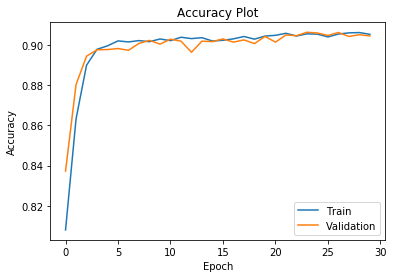

In [52]:
plt.plot(model_history.history['acc'])
plt.plot(model_history.history['val_acc'])
plt.title('Accuracy Plot')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

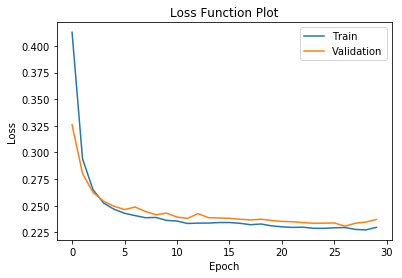

In [53]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Loss Function Plot')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

#### Visualize the above plots and analyze the Train and Validation curves

### Experimenting with Hidden Layers - Build your own Neural Network

### Exercise: Experiment with learning rates

### Reference Links:

https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/

https://keras.io/